In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [4]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [6]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.316334
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in* 



In [ ]:
# 因为我们的权重矩阵乘以0.001之后导致里面的值都非常小，接近于0，所以我们得到的分值向量里的值也都接近于0。0经过指数化接近1，因为一共有10个类别，之后的归一化会导致正确类别的概率值接近于0.1（等概论1/10），所以根据损失函数的定义得到损失值将接近-log（0.1）

In [7]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# 使用数值梯度检验的方法作为调试工具

# 数值梯度(求导）应接近解析梯度（链式求导）
# grad_check_sparse这个函数随机抽取10个位置，然后打印出该位置的数值梯度和分析梯度，以及它们之间的相对差值
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.814390 analytic: -2.814390, relative error: 1.696286e-08
numerical: 0.576131 analytic: 0.576131, relative error: 9.157572e-09
numerical: 0.034264 analytic: 0.034264, relative error: 7.724236e-07
numerical: -1.148356 analytic: -1.148356, relative error: 2.262229e-08
numerical: 0.577577 analytic: 0.577577, relative error: 3.281225e-08
numerical: -3.021821 analytic: -3.021821, relative error: 4.852285e-09
numerical: 1.844924 analytic: 1.844924, relative error: 3.016029e-08
numerical: 0.933658 analytic: 0.933658, relative error: 1.780029e-09
numerical: -4.788551 analytic: -4.788552, relative error: 8.966809e-09
numerical: -1.890758 analytic: -1.890758, relative error: 3.410880e-09
numerical: 1.384232 analytic: 1.384232, relative error: 6.459047e-09
numerical: 0.368538 analytic: 0.368538, relative error: 1.625975e-09
numerical: -0.224999 analytic: -0.224999, relative error: 7.000076e-09
numerical: 1.222099 analytic: 1.222099, relative error: 4.354567e-09
numerical: -3.216199 a

In [8]:
# 我们已经有了一个朴素版的softmax损失函数及其梯度的实现，现在在softmax_loss_vectorized函数中再实现一个向量版的函数。这两个函数的结果应该是一样的，只是向量版的速度运算速度会快很多。
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.316334e+00 computed in 0.052088s
vectorized loss: 2.316334e+00 computed in 0.079144s
Loss difference: 0.000000
Gradient difference: 0.000000


In [13]:
# 超参数调优：利用验证集来微调超参数（正则化强度和学习率），你应该分别使用不同的数值范围对学习率和正则化强度进行微调。如果足够细心，你应该能在验证集上实现高于0.35的分类准确率

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# 使用更细致的学习率和正则化强度       
#用验证集来调整学习率和正则化强度；这跟你在SVM里做的类似；把最好的Softmax分类器保存在best_softmax里
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]
#上面这两个范围是题目给的，下面是答案做的
learning_rates = np.logspace(-10,10,10)
regularization_strengths = np.logspace(-3,6,10)
#np.logspace(start, stop, num=50, endpoint=True, base=10.0, dtype=None)
# 其中，start和stop表示指定范围的起始值和终止值，num表示生成数列的个数（默认为50个），endpoint表示是否包括终止值（默认为True），base表示底数（默认为10），dtype表示返回数列的数据类型（默认为float）。
#[1e-11,...1e11]一共十个数的等比数列  [1e-4...1e7]一共十个数的等比数列
iters = 100
for lr in learning_rates:
    for rs in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train,y_train,learning_rate = lr,reg = rs,num_iters = iters)
        
        y_train_pred = softmax.predict(X_train)
        acc_train = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        acc_val = np.mean(y_val == y_val_pred)

        results[(lr,rs)] = (acc_train,acc_val)
        
        if best_val<acc_val:
            best_val = acc_val
            best_softmax = softmax
        
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-10 reg 1.000000e-03 train accuracy: 0.140265 val accuracy: 0.146000
lr 1.000000e-10 reg 1.000000e-02 train accuracy: 0.111163 val accuracy: 0.121000
lr 1.000000e-10 reg 1.000000e-01 train accuracy: 0.083939 val accuracy: 0.075000
lr 1.000000e-10 reg 1.000000e+00 train accuracy: 0.110469 val accuracy: 0.120000
lr 1.000000e-10 reg 1.000000e+01 train accuracy: 0.105163 val accuracy: 0.113000
lr 1.000000e-10 reg 1.000000e+02 train accuracy: 0.090204 val accuracy: 0.083000
lr 1.000000e-10 reg 1.000000e+03 train accuracy: 0.105367 val accuracy: 0.116000
lr 1.000000e-10 reg 1.000000e+04 train accuracy: 0.118408 val accuracy: 0.108000
lr 1.000000e-10 reg 1.000000e+05 train accuracy: 0.100408 val accuracy: 0.105000
lr 1.000000e-10 reg 1.000000e+06 train accuracy: 0.088245 val accuracy: 0.076000
lr 1.668101e-08 reg 1.000000e-03 train accuracy: 0.128653 val accuracy: 0.125000
lr 1.668101e-08 reg 1.000000e-02 train accuracy: 0.123449 val accuracy: 0.117000
lr 1.668101e-08 reg 1.000000

In [14]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.346000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



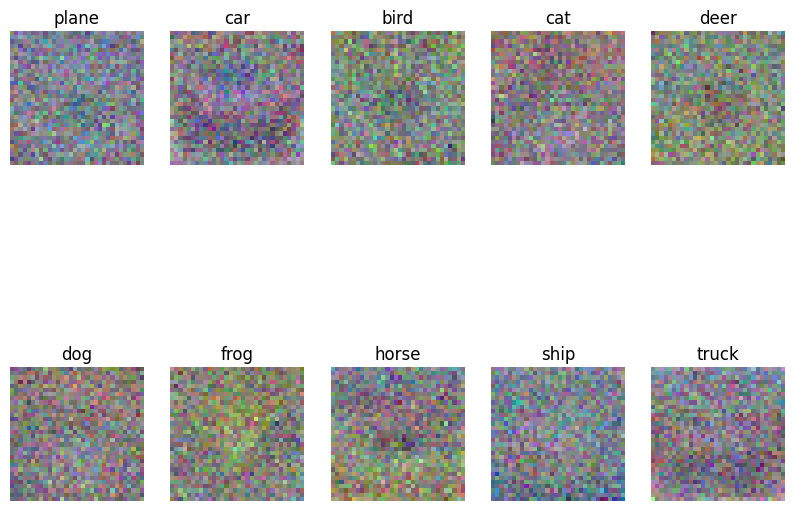

In [15]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
#     .squeeze()是一个numpy函数，用于从数组的形状中删除单维度条目，即将长度为1的维度删除。如果数组的某个维度长度为1，则该维度可以被视为没有意义，因为它只包含一个元素。使用.squeeze()函数可以将这样的维度删除，从而使数组更易于处理。
# 例如，如果一个数组的形状为(1, 2, 1, 3, 1)，则使用.squeeze()函数后，形状将变为(2, 3)，其中原来的单维度条目被删除。如果数组中没有单维度条目，则.squeeze()函数不会改变数组的形状。plt.imshow(wimg.astype('uint8'))
# 这段代码用于将一个卷积神经网络中的卷积核可视化成一张图片。具体来说，它将第i个卷积核从4维张量w中提取出来，然后将其值缩放到0到255之间，最后将其保存在一个大小为32x32的二维数组wimg中。
# .squeeze()函数的作用是将w[:, :, :, i]的形状从(32, 32, 3, 1)变成(32, 32, 3)，即删除长度为1的维度。这是因为在卷积神经网络中，卷积核的深度（即通道数）通常为1，因此可以将这一维度删除，使得得到的二维数组可以被视为一张RGB图像。
# 其中，w_min和w_max分别是所有卷积核的最小值和最大值，用于将卷积核的值缩放到0到255之间。这样做是为了使得卷积核中的模式更加明显，便于观察。
    plt.axis('off')
    plt.title(classes[i])